## CUDA with CuPy

In [2]:
import numpy as np
import cupy as cp

#### Create numpy like array on host and device

In [ ]:
# array on host memory
x_host = np.array([1,2,3])
type(x_host)

numpy.ndarray

In [ ]:
# array on device memory
x_device = cp.array([1,2,3])
type(x_device)

cupy.ndarray

## Norm operation on CPU and GPU
 (CPU is much Faster for smaller Array sizes due to faster single thread preformance and memory interconnect overheads between GPU and host)

In [ ]:
%%timeit
np.linalg.norm(x_host)

In [ ]:
%%timeit
cp.linalg.norm(x_device)

## To select which Device to run on

In [ ]:
with  cp.cuda.Device(0):
  x_on_device_0 = cp.array([1,2,3])
  print(x_on_device_0)

## Transfer data between Host and Device

In [ ]:
# create numpy array on host
x_host = np.random.randint(0,255,(1000,1000))

In [ ]:
# Transfer numpy array to device
x_device = cp.asarray(x_host)

In [ ]:
# Transfer cupy array from device to array
x_host  = x_device.get()

## Compute FFT
creating a large array in python, then applying FFT on it

In [ ]:
from scipy.fft import fftn

In [ ]:
%%timeit
fftn(x_host)

Now with GPU

In [ ]:
import cupyx

In [ ]:
%%timeit
cupyx.scipy.fft.fftn(x_device)

1.23 ms ± 4.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Sorting an array
creating a large array in python, then sorting it with the sort() function of NumPy on the CPU.


In [ ]:
size = 8192 * 8192
array = np.random.random(size).astype(np.float32)

%timeit result = np.sort(array)

1.07 s ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


let’s perform the same sorting, but this time on a GPU. We will be using the sort() function from CuPy


In [ ]:
array_gpu = cp.asarray(array)
%timeit result_gpu = cp.sort(array_gpu)

34.6 ms ± 4.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# CUDA with Numba

In [3]:
from numba import cuda
import numpy as np
import math

In [ ]:
x_host = np.ones(shape=(28932))

In [ ]:
def host_incrementByOne(array):
    for i in range(len(array)):
      array[i] += 1

In [ ]:
%%timeit
host_incrementByOne(x_host)

8.59 ms ± 2.37 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Cuda Thread
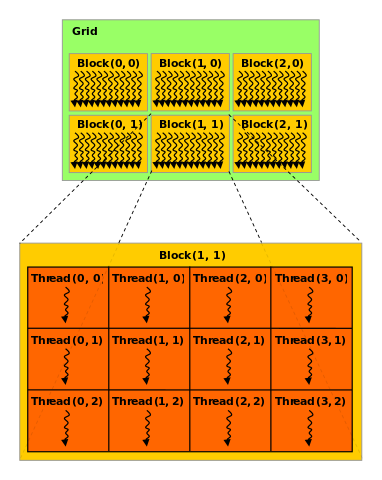

In [ ]:
@cuda.jit
def device_incrementByOne(array):
  # thread id in a 1D block
  tx = cuda.threadIdx.x
  # block id in a 1D grid
  ty = cuda.blockIdx.x
  # block width, i.e. the number of threads per block
  bw = cuda.blockDim.x
  # compute flattened index inside array
  pos = tx + ty * bw
  if pos < array.size:  # check array boundaries
    array[pos] += 1

In [ ]:
x_host = np.ones(shape=(28932))
x_device = cuda.to_device(x_host)
threadsperblock = 256
blockspergrid = (x_device.size + (threadsperblock - 1)) // threadsperblock

In [ ]:
%%timeit
device_incrementByOne[blockspergrid, threadsperblock](x_device)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 114 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


43.1 µs ± 9.48 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
@cuda.jit
def device_incrementByOne(array):
  pos = cuda.grid(1)
  if pos < array.size:  # check array boundaries
    array[pos] += 1

In [ ]:
x_device.copy_to_host()

array([243342., 243342., 243342., ..., 243342., 243342., 243342.])

Example with 2 Dimensional Data

In [4]:
x_device = cuda.to_device(np.ones(shape=(256,256)))

In [10]:
@cuda.jit
def deviceIncrement2D(array):
  x,y = cuda.grid(2)
  if x < array.shape[0] and y < array.shape[1]:
    array[x,y] += 1


In [11]:
threadsperblock = (16,16)
blockspergrid_x = math.ceil(x_device.shape[0]/threadsperblock[0])
blockspergrid_y = math.ceil(x_device.shape[1]/threadsperblock[1])
blockspergrid = (blockspergrid_x,blockspergrid_y)


In [12]:
%%timeit
deviceIncrement2D[blockspergrid,threadsperblock](x_device)


235 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We can use cupy arrays as well

In [14]:
import cupy as cp
x_device = cp.ones(shape = (256,256))
deviceIncrement2D[blockspergrid, threadsperblock](x_device)

In [15]:
print(type(x_device))
x_device

<class 'cupy.ndarray'>


array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

## Vector Addition

In [3]:
import numpy as np
from numba import cuda, float32
import math

In [18]:
@cuda.jit
def f(a,b,c):
  pos = cuda.grid(1)
  size = len(c)
  if pos < size:
    c[pos] = a[pos] + b[pos]

In [16]:
N = 1000000
a = cuda.to_device(np.random.random(N))
b = cuda.to_device(np.random.random(N))
c = cuda.device_array_like(a)

forall() crates 1D grid for a given data size

In [22]:
f.forall(len(a))(a,b,c)
c.copy_to_host()

array([1.85478028, 0.8784233 , 0.82167347, ..., 1.02163368, 1.78232699,
       0.52496273])

In [23]:
nthreads = 256
nblocks = (len(a) // nthreads) + 1
f[nblocks, nthreads](a,b,c)
c.copy_to_host()

array([1.85478028, 0.8784233 , 0.82167347, ..., 1.02163368, 1.78232699,
       0.52496273])

Matrix Multiplication

In [4]:
@cuda.jit
def matmul (A, B, C):
  # Perform square matrix multiplication of C = A * B
  i, j = cuda.grid(2)
  if i < C.shape[0] and j < C.shape[1]:
    tmp = 0.
    for k in range(A.shape[1]):
      tmp + A[i, k] * B[k, j]
    C[i, j] = tmp

x_h = np.arange(16).reshape([4, 4])
y_h = np.ones([4, 4])
z_h = np.zeros([4, 4])

x_d = cuda.to_device(x_h)
y_d = cuda.to_device(y_h)
z_d = cuda.to_device(z_h)

In [2]:
threadsperblock = (16, 16)
blockspergrid_x = math.ceil(z_h.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(z_h.shape[1] / threadsperblock [1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](x_d, y_d, z_d)
z_h = z_d.copy_to_host()

NameError: name 'math' is not defined

Better MAtrix Multiplication with Shared Memory

In [5]:
TPB = 16 # threads per block
@cuda.jit
def fast_matmul (A, B, C):
  # Define an array in the shared memory
  # The size and type of the arrays must be known at compile time
  sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
  sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
  x, y = cuda.grid(2)
  tx = cuda.threadIdx.x
  ty = cuda.threadIdx.y
  bpg = cuda.gridDim.x

  # Each thread computes one element in the result matrix.
  # The dot product is chunked into dot products of TPB-long vectors.
  tmp = float32(0.)
  for i in range(bpg):
    # Preload data into shared memory
    sA[ty, tx] = 0
    sB[ty, tx] = 0
    if y<A.shape[0] and (tx + i * TPB) < A.shape[1]:
      sA[ty, tx] = A[y, tx + i * TPB]
    if x < B.shape[1] and (ty + i * TPB) < B.shape[0]:
      sB[ty, tx] = B[ty + i * TPB, x]

    # Wait until all threads finish preloading
    cuda.syncthreads()

    # Computes partialp product on the shared memory
    for j in range(TPB):
      tmp += sA[ty, j] * sB[j, tx]

    # Wait until all threads finish computing
    cuda.syncthreads()
  if y < C.shape[0] and x < C.shape[1]:
    C[y,x] = tmp

NameError: name 'cuda' is not defined